## 이미지로부터 마스크 탐지 
* 딥러닝 기반의 face detection과 mask detection 적용코드
* 주의 : 학습코드 아님. 기존의 학습된 모델을 이용하여 inference.

In [2]:
# tensorflow 2+
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input # scaling 모듈
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

plt.style.use('dark_background')   # matplotlib img 백그라운드 다크모드

# Load Models

In [62]:
# face detector(cv model), mask detector(tf.keras model) 모델 로딩
# cv2 dnn은 네트워크 구성이 저장된 파일과 훈련된 가중치를 로드함.
facenet = cv2.dnn.readNet('models/deploy.prototxt', 
                          'models/res10_300x300_ssd_iter_140000.caffemodel') # caffemodel 파일 : 얼굴 인식을 위해 ResNet 기본 네트워크를 사용하는 SSD(Single Shot Detector) 프레임워크를 통해 사전 훈련된 모델 가중치 사
model = load_model('models/mask_detector.model')  # keras

# Load Image

(306, 500, 3)


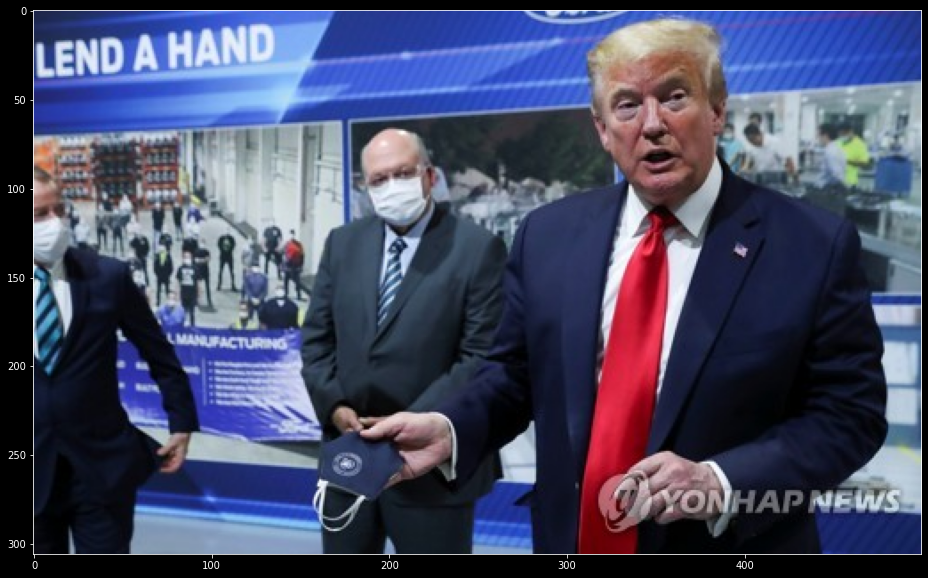

In [6]:
img = cv2.imread('imgs/02.jpg')
h, w = img.shape[:2]
print(img.shape)    # (306, 500, 3) - h, w, c

plt.figure(figsize=(16, 10))
plt.imshow(img[:, :, ::-1])   # BGR -> RGB

# Preprocess Image for Face Detection
참고: openCV 의 DNN프로세스
* TF, Caffe, Pytorch와 같은 딥러닝 프레임워크에서 훈련된 모델을 로드, 전처리, inference를 진행할 수 있게 하는 opencv 함수.
* 4가지 모듈이 있음
  * readNetFrom : 딥러닝 모델 및 환경설정 파일 로드
  * blobFromImage : 이미지 전처리(4차원dim생성, 크기조정, 평균값을 빼고, 배율로 값 조정, 빨강-파랑 채널을 서로 바꿈 BGRtoRGB)
  * setInput : blobFromImage에서 나온 array를 입력설정
  * forward: inference
* 참고 sites :
  * https://wiserloner.tistory.com/892
  * https://deep-learning-study.tistory.com/299
  
  ----
  
```python
cv2.dnn.blobFromImage(image, scalefactor=None, size=None, mean=None, swapRB=None, crop=None, ddepth=None)

* image: 입력 영상
* scalefactor: 입력 영상 픽셀 값에 곱할 값. 기본값은 1.
   * 딥러닝 학습을 진행할 때 입력 영상을 0~255 픽셀값을 이용했는지, 0~1로 정규화해서 이용했는지에 맞게 지정해줘야 합니다. 0~1로 정규화하여 학습을 진행했으면 1/255를 입력해줘야 합니다.
* size: 출력 영상의 크기. 기본값은 (0, 0).
* mean: 입력 영상 각 채널에서 뺄 평균 값. 기본값은 (0, 0, 0, 0).
* swapRB: R과 B 채널을 서로 바꿀 것인지를 결정하는 플래그. 기본값은 False.
* crop: 크롭(crop) 수행 여부. 기본값은 False.
* ddepth: 출력 블롭의 깊이. CV_32F 또는 CV_8U. 기본값은 CV_32F.
* retval: 영상으로부터 구한 블롭 객체. numpy.ndarray. shape=(N,C,H,W). dtype=numpy.float32.
```

In [47]:
# dnn모듈이 사용하는 형태로 이미지를 변형(1.img size 변경, 2. dim 순서변경(B, C, W, H), 3.scaling(x-mean), 4.BGR->RGB)
# scalefactor : 입력 영상 픽셀 값에 곱할 값(스케일 변형) (1: no scaling)
# mean 값은 모델 학습에 참여한 데이터의 평균이 됨.
blob = cv2.dnn.blobFromImage(img, scalefactor=1., size=(300, 300), mean=(104., 177., 123.))
print(type(blob), blob.shape)    # np, (1, 3, 300, 300)
facenet.setInput(blob)   # input
dets = facenet.forward() # inference
print(type(dets), dets.shape)     # np, (1, 1, 200, 7) ? 뭐지

<class 'numpy.ndarray'> (1, 3, 300, 300)
<class 'numpy.ndarray'> (1, 1, 200, 7)


### cv2.dnn.blobFromImage로 preprocessing 하기 전과 후 값 차이 비교

전처리 전/후 픽셀 값의 분포 확인.

In [14]:
import pandas as pd

0 255


<AxesSubplot:>

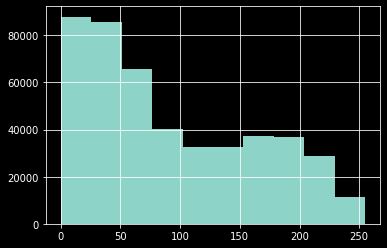

In [32]:
img_series_before = pd.Series(img.ravel())
print(img.min(), img.max())
img_series_before.hist()

-177.0 151.0


<AxesSubplot:>

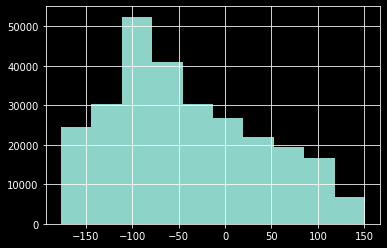

In [33]:
img_series_after = pd.Series(blob.ravel())
print(blob.min(), blob.max())
img_series_after.hist()

### cv2.dnn.blob~() 는 mean값을 채널마다 빼준다고 함. 검증.
* 결과 : 실제로 각 채널에서 설정한 mean값을 전체 픽셀에 대하여 단순히 빼는 과정.

In [31]:
# 전처리 전 이미지, 각 채널의 픽셀값 평균
img[:,:,0].mean(), img[:,:,1].mean(), img[:,:,2].mean()

(114.71332679738562, 83.63823529411765, 79.16624183006536)

In [46]:
# 전처리 후 각 채널의 픽셀값 평균
blob[0, 0,:,:].mean(), blob[0, 1,:,:].mean(), blob[0, 2,:,:].mean()

(10.603822, -93.47113, -43.94051)

In [38]:
# 직접 빼서 확인 - 위의 blob array 결과와 같음
test_img = img - [104., 177., 123.]
test_img.shape
test_img[:,:,0].mean(), test_img[:,:,1].mean(), test_img[:,:,2].mean()

(10.713326797385621, -93.36176470588235, -43.83375816993464)

# Detect Faces
모델 학습 코드를 봐야지만 output 의 shape가 이해가 될것 같음.

In [49]:
print(type(dets), dets.shape)     # np, (1, 1, 200, 7) ? 뭐지

<class 'numpy.ndarray'> (1, 1, 200, 7)


In [52]:
# 7의 결과: (?, ?, confidence, x1, y1, x2, y2)
dets[0, 0, i, :]

array([0.        , 1.        , 0.87944996, 0.3703808 , 0.2248977 ,
       0.4419913 , 0.3990782 ], dtype=float32)

(89, 60, 3)
(54, 35, 3)


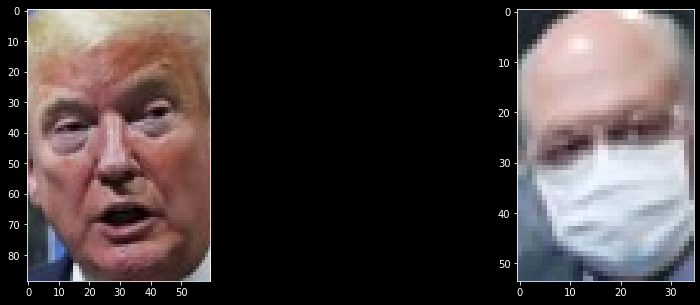

In [53]:
faces = []

for i in range(dets.shape[2]):  ## 200회 돌기
    confidence = dets[0, 0, i, 2]  ## 왜 이게 confidence? 
    if confidence < 0.5:
        continue

    # bnd box 구하기
    x1 = int(dets[0, 0, i, 3] * w)
    y1 = int(dets[0, 0, i, 4] * h)
    x2 = int(dets[0, 0, i, 5] * w)
    y2 = int(dets[0, 0, i, 6] * h)
    
    # 얼굴만자름
    face = img[y1:y2, x1:x2]
    print(face.shape)
    faces.append(face)

plt.figure(figsize=(16, 5))

for i, face in enumerate(faces):
    plt.subplot(1, len(faces), i+1)
    plt.imshow(face[:, :, ::-1])

# Detect Masks from Faces

preprocess전 (224, 224, 3) 0 245
preprocess후 (224, 224, 3) -1.0 0.92156863
(1, 2) [[1.9568048e-04 9.9980432e-01]]
(2,) [1.9568048e-04 9.9980432e-01]

preprocess전 (224, 224, 3) 15 255
preprocess후 (224, 224, 3) -0.88235295 1.0
(1, 2) [[9.9985909e-01 1.4082667e-04]]
(2,) [9.9985909e-01 1.4082667e-04]



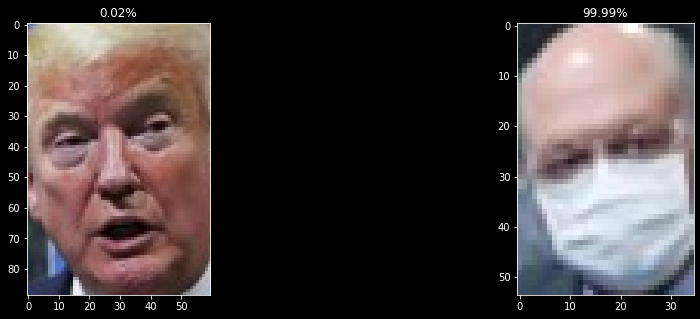

In [61]:
plt.figure(figsize=(16, 5))

for i, face in enumerate(faces):  # 얼굴 갯수만큼 
    # 전처리 (resize, BGRtoRGB, Batch추가)
    face_input = cv2.resize(face, dsize=(224, 224))
    face_input = cv2.cvtColor(face_input, cv2.COLOR_BGR2RGB)
    print('preprocess전', face_input.shape, face_input.min(), face_input.max())
    face_input = preprocess_input(face_input)    # scaling (-1 - 1) https://keras.io/api/applications/mobilenet/
    print('preprocess후', face_input.shape, face_input.min(), face_input.max())
    face_input = np.expand_dims(face_input, axis=0)  # 차원 추가 1, 224, 224, 3
    
    # mask쓴확률, 안쓴확률이 나타난다.
    aaa = model.predict(face_input)
    print(aaa.shape, aaa)    # (1, 2) [[1.9568048e-04 9.9980432e-01]]
    bbb = aaa.squeeze()    # 맨 앞 차원 제거
    print(bbb.shape, bbb)    # (2,) [1.9568048e-04 9.9980432e-01]
    mask, nomask = model.predict(face_input).squeeze()
    print()
    plt.subplot(1, len(faces), i+1)
    plt.imshow(face[:, :, ::-1])
    plt.title('%.2f%%' % (mask * 100))